# Calculate and Align Daily Sentiment Indicators

This notebook aligns three types of data:
1. Daily sentiment scores from FinBERT (financial tweets) and RoBERTa (non-financial tweets)
2. NVDA daily stock prices
3. VIX index data

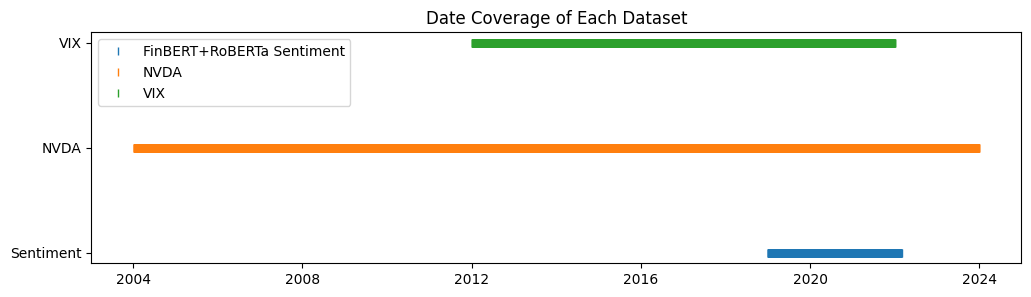


After inner join:
Total days: 757

Missing values per column:
index                  0
avg_sentiment_score    0
tweet_count            0
sentiment_std          0
model_type             0
nvda_open              0
nvda_high              0
nvda_low               0
nvda_close             0
nvda_return            0
vix_close              0
dtype: int64

Overlapping dates (total 757):
From: 2019-01-02
To: 2021-12-31
Index(['index', 'avg_sentiment_score', 'tweet_count', 'sentiment_std',
       'model_type', 'nvda_open', 'nvda_high', 'nvda_low', 'nvda_close',
       'nvda_return', 'vix_close'],
      dtype='object')
       index  avg_sentiment_score  tweet_count  sentiment_std  \
0 2019-01-02            -0.028037          214       0.463867   
1 2019-01-03            -0.021352          281       0.470076   
2 2019-01-04             0.000000          210       0.403335   
3 2019-01-07             0.055147          272       0.421615   
4 2019-01-08            -0.029333          375       0.409

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# read sentiment score
daily_sent = pd.read_csv("../2_data/daily_sentiment_combined.csv", parse_dates=["date"])
# only keep Finbert+RoBERTa result
daily_sent = daily_sent[daily_sent['model_type'] == 'FinBERT+RoBERTa']
daily_sent = daily_sent.set_index("date")

# read nvda stock price
nvda = pd.read_csv("../2_data/nvidia_stock_prices.csv", parse_dates=["Date"])
nvda = nvda.rename(columns={
    "Open": "nvda_open",
    "High": "nvda_high",
    "Low": "nvda_low",
    "Close": "nvda_close"
})
nvda = nvda.sort_values("Date")
nvda["nvda_return"] = nvda["nvda_close"].pct_change()

nvda_data = nvda[["Date", "nvda_open", "nvda_high", "nvda_low", "nvda_close", "nvda_return"]].set_index("Date")
nvda_close = nvda_data.dropna(subset=["nvda_return"])


# read vix
vix = pd.read_csv("../2_data/vix_data.csv", parse_dates=["Date"])
vix = vix.rename(columns={"Close": "vix_close"})
vix = vix.sort_values("Date")
vix_close = vix[["Date", "vix_close"]].set_index("Date")

# get the date range for each dataset
sent_dates = set(daily_sent.index.date)
nvda_dates = set(nvda_close.index.date)
vix_dates = set(vix_close.index.date)

# visualization
plt.figure(figsize=(12, 3))
plt.plot(sorted(sent_dates), [1]*len(sent_dates), '|', label='FinBERT+RoBERTa Sentiment')
plt.plot(sorted(nvda_dates), [2]*len(nvda_dates), '|', label='NVDA')
plt.plot(sorted(vix_dates), [3]*len(vix_dates), '|', label='VIX')
plt.yticks([1,2,3], ['Sentiment', 'NVDA', 'VIX'])
plt.title("Date Coverage of Each Dataset")
plt.legend()
plt.show()

# inner merge
merged_inner = (daily_sent
    .join(nvda_close[["nvda_open", "nvda_high", "nvda_low", "nvda_close", "nvda_return"]], how="inner")
    .join(vix_close, how="inner")
    .reset_index()
)

print("\nAfter inner join:")
print("Total days:", len(merged_inner))
print("\nMissing values per column:")
print(merged_inner.isnull().sum())

merged_inner.to_csv("../2_data/sentiment_price_vix_inner_aligned.csv", index=False)

# visualize overlap
overlap_dates = sorted(sent_dates & nvda_dates & vix_dates)
print(f"\nOverlapping dates (total {len(overlap_dates)}):")
print(f"From: {min(overlap_dates)}")
print(f"To: {max(overlap_dates)}")
print(merged_inner.columns)
print(merged_inner.head())

In [1]:
import pandas as pd
from tqdm import tqdm
import re

def classify_financial_text(text):
    """
    判断文本是否包含金融相关术语
    """
    try:
        financial_pattern = r'\b(?:\$[A-Z]{1,5}\b|stock(?:\s*price|s?)|price\s*target|market\s*(?:cap|value)|' \
                          r'shares|share\s*price|earnings(?:\s*report|per\s*share|call)|semiconductor|chip\s*industry|' \
                          r'invest(?:ing|ment)|trading|portfolio|dividend|buyback|' \
                          r'\b(?:bull|bear)(?:ish|market)\b|valuation|P/E|price-to-earnings|' \
                          r'analyst\s*rating|upgrade|downgrade|(?:financial|quarterly)\s*results|' \
                          r'volume|liquidity|SEC\s*filing|10-[KQ]|IPO|FPO|secondary\s*offering)'
        
        return bool(re.search(financial_pattern, str(text), flags=re.IGNORECASE))
    except Exception as e:
        print(f"Error in classify_financial_text: {str(e)}")
        return False

def main():
    # 1. 加载数据
    print("Loading data...")
    df = pd.read_csv("../2_data/cleaned_nvda.csv")
    initial_count = len(df)
    
    # 2. 使用进度条显示分类过程
    print("Classifying financial tweets...")
    tqdm.pandas(desc="Processing")
    df['is_financial'] = df['Cleaned_Tweet'].progress_apply(classify_financial_text)
    
    # 3. 只保留金融相关推文
    df_financial = df[df['is_financial']]
    final_count = len(df_financial)
    
    # 4. 保存结果
    output_path = "../2_data/financial_tweets_only.csv"
    df_financial.to_csv(output_path, index=False)
    
    # 5. 打印统计信息
    print("\nFiltering Results:")
    print(f"Original tweets: {initial_count:,}")
    print(f"Financial tweets: {final_count:,}")
    print(f"Removed tweets: {initial_count - final_count:,}")
    print(f"Financial tweets percentage: {(final_count/initial_count)*100:.2f}%")
    print(f"\nSaved financial tweets to: {output_path}")

if __name__ == "__main__":
    main()

Loading data...
Classifying financial tweets...
Classifying financial tweets...


Processing: 100%|██████████| 501908/501908 [00:03<00:00, 155275.25it/s]




Filtering Results:
Original tweets: 501,908
Financial tweets: 65,921
Removed tweets: 435,987
Financial tweets percentage: 13.13%

Saved financial tweets to: ../2_data/financial_tweets_only.csv


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

def merge_sentiment_scores():
    # 1. 加载数据
    print("Loading data files...")
    financial_tweets = pd.read_csv("../2_data/financial_tweets_only.csv")
    sentiment_data = pd.read_csv("../2_data/tweet_level_sentiment.csv")
    
    # 2. 确保日期格式一致
    financial_tweets['Date'] = pd.to_datetime(financial_tweets['Date'])
    sentiment_data['Date'] = pd.to_datetime(sentiment_data['Date'])
    
    # 3. 合并数据
    print("Merging sentiment scores...")
    # 使用Date和Processed_Tweet列作为合并键
    merged_df = pd.merge(
        financial_tweets,
        sentiment_data[['Date', 'Processed_Tweet', 'sentiment_score', 'sentiment_label']],
        how='left',
        on=['Date', 'Processed_Tweet']
    )
    
    # 4. 检查合并结果
    print("\nMerge Results:")
    print(f"Original financial tweets: {len(financial_tweets)}")
    print(f"After merging: {len(merged_df)}")
    print(f"Missing sentiment scores: {merged_df['sentiment_score'].isnull().sum()}")
    
    # 5. 保存结果
    output_path = "../2_data/financial_tweets_with_sentiment.csv"
    merged_df.to_csv(output_path, index=False)
    print(f"\nSaved merged data to: {output_path}")
    
    # 6. 显示每日平均情感分数
    daily_sentiment = merged_df.groupby('Date')['sentiment_score'].agg([
        'mean',
        'count',
        'std'
    ]).reset_index()
    
    print("\nDaily Sentiment Score Summary:")
    print(daily_sentiment.head())
    
    return merged_df

if __name__ == "__main__":
    merged_df = merge_sentiment_scores()

Loading data files...


/var/folders/rn/lc8n68_d7ld6yymqc_lsnrr00000gn/T/ipykernel_11550/91661345.py:9: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  sentiment_data = pd.read_csv("../2_data/tweet_level_sentiment.csv")


Merging sentiment scores...

Merge Results:
Original financial tweets: 65921
After merging: 68113
Missing sentiment scores: 27556

Saved merged data to: ../2_data/financial_tweets_with_sentiment.csv

Daily Sentiment Score Summary:
        Date  mean  count  std
0 2013-04-11   NaN      0  NaN
1 2013-04-12   NaN      0  NaN
2 2013-04-13   NaN      0  NaN
3 2013-04-15   NaN      0  NaN
4 2013-04-17   NaN      0  NaN

Saved merged data to: ../2_data/financial_tweets_with_sentiment.csv

Daily Sentiment Score Summary:
        Date  mean  count  std
0 2013-04-11   NaN      0  NaN
1 2013-04-12   NaN      0  NaN
2 2013-04-13   NaN      0  NaN
3 2013-04-15   NaN      0  NaN
4 2013-04-17   NaN      0  NaN
